In [1]:
import sys
import os
sys.path.append(os.path.abspath('../../'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor, MOGPRegressor_NC, MORCGPRegressor_NC, MORCGPRegressor_NC_fixed_weights, MORCGPRegressor_fixed_weights, MORCGPRegressor_PM, MORCGP
from rcgp.rcgp import RCGPRegressor
from rcgp.kernels import ConstantMean, RBFKernel, SineMean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import cholesky
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 4,    
    'lines.markersize': 5   
})

In [2]:
def train_test_split_random(x, Y, N_train):
    total_samples = x.shape[0]
    all_indices = np.arange(total_samples)
    
    train_indices = np.random.choice(all_indices, size=N_train, replace=False)
    test_indices = np.setdiff1d(all_indices, train_indices)
    
    train_indices = np.sort(train_indices)
    test_indices = np.sort(test_indices)
    
    x_train = x[train_indices]
    Y_train = Y[train_indices]
    x_test = x[test_indices]
    Y_test = Y[test_indices]
    
    return x_train, Y_train, x_test, Y_test

def rbf_kernel(x1, x2, lengthscale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2,1) - 2*np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / lengthscale**2 * sqdist)

def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

In [28]:
rmses_mogp, rmses_morcgp = [], []
nlpds_mogp, nlpds_morcgp = [], []

introduce_outliers = True
introduce_missing_values = True

N, D = 120, 2
noise_var = 0.1
epsilon = 0.1

lengthscale = 0.2
rbf_variance = 1.0

for i in tqdm(range(20)):
    np.random.seed(i)

    correlation = np.random.uniform(0.7, 1.0)

    if introduce_outliers:
        prop_outliers = 0.2
    else:
        prop_outliers = 0.0

    B = np.array([
        [1.0, correlation],
        [correlation, 1.0],
    ])
    A = np.linalg.cholesky(B)

    x = np.sort(np.random.uniform(-5, 5, N)).reshape(-1, 1)
    Kx = rbf_kernel(x, x, lengthscale=lengthscale, variance=rbf_variance)
    K = np.kron(B, Kx)

    # Add a small jitter for numerical stability
    L = cholesky(K + 1e-6*np.eye(D*N), lower=True)

    f_samples = L @ np.random.randn(D*N)
    F = f_samples.reshape(D, N).T
    Y_test = F + np.random.normal(0, noise_var, F.shape)
    Y_train = Y_test.copy()

    if introduce_outliers:
        n_outliers = int(prop_outliers * N)
        outlier_idx = np.random.choice(N, n_outliers, replace=False)

        # Flip a coin: +1 = positive outlier, -1 = negative outlier
        coin_flips = np.random.choice([-1, 1], size=n_outliers)

        # Base uniform samples between [6, 9] for first column only
        base_samples = np.random.uniform(6, 12, size=n_outliers)

        # Apply coin flips
        outliers = base_samples * coin_flips

        # Insert into first column of Y
        Y_train[outlier_idx, 0] = outliers

    if introduce_missing_values:
        mask = (x[:, 0] >= -2) & (x[:, 0] <= 2)
        Y_train[mask, 1] = np.nan

    # MOGP
    mogp = MOGPRegressor(mean=0, length_scale=1.0, noise = np.array([0.1] * D), A = 2*A)
    mogp.fit(x, Y_train)
    mogp.optimize_hyperparameters(print_opt_param=False, print_iter_param=False)
    mu_mogp, var_mogp = mogp.predict(x)
    std_mogp = np.sqrt(var_mogp + mogp.noise)

    # MORCGP
    Y_train_clean = Y_train[~np.isnan(Y_train).any(axis=1)]
    mcd = MinCovDet(support_fraction=1-prop_outliers).fit(Y_train_clean)
    robust_covariance = mcd.covariance_

    morcgp = MORCGP(mean=0, length_scale=1, noise_var=np.array([0.1]*D), A=A)
    morcgp.fit(x, Y_train, epsilons=np.array([prop_outliers, 0]))
    init_gamma, init_c, gamma, c = morcgp.optimize_loo_cv(print_opt_param=False, print_iter_objective=False, k=1, init_cov=robust_covariance, fix_weights=False)

    mu_morcgp, var_morcgp = morcgp.predict(x)
    std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

    rmse_mogp = calculate_rmse(Y_test, mu_mogp)
    rmse_morcgp = calculate_rmse(Y_test, mu_morcgp)

    nlpd_mogp = nlpd(Y_test, mu_mogp, std_mogp**2)
    nlpd_morcgp = nlpd(Y_test, mu_morcgp, std_morcgp**2)

    rmses_mogp.append(rmse_mogp)
    rmses_morcgp.append(rmse_morcgp)
    nlpds_mogp.append(nlpd_mogp)
    nlpds_morcgp.append(nlpd_morcgp)

print("MOGP RMSE: {:.4f} ± {:.4f}".format(np.mean(rmses_mogp), np.std(rmses_mogp)))
print("MORCGP RMSE: {:.4f} ± {:.4f}".format(np.mean(rmses_morcgp), np.std(rmses_morcgp)))
print("MOGP NLPD: {:.4f} ± {:.4f}".format(np.mean(nlpds_mogp), np.std(nlpds_mogp)))
print("MORCGP NLPD: {:.4f} ± {:.4f}".format(np.mean(nlpds_morcgp), np.std(nlpds_morcgp)))


100%|██████████| 20/20 [02:57<00:00,  8.88s/it]

MOGP RMSE: 0.7710 ± 0.2033
MORCGP RMSE: 0.4481 ± 0.1419
MOGP NLPD: 1.2091 ± 0.1828
MORCGP NLPD: 0.8704 ± 0.2297


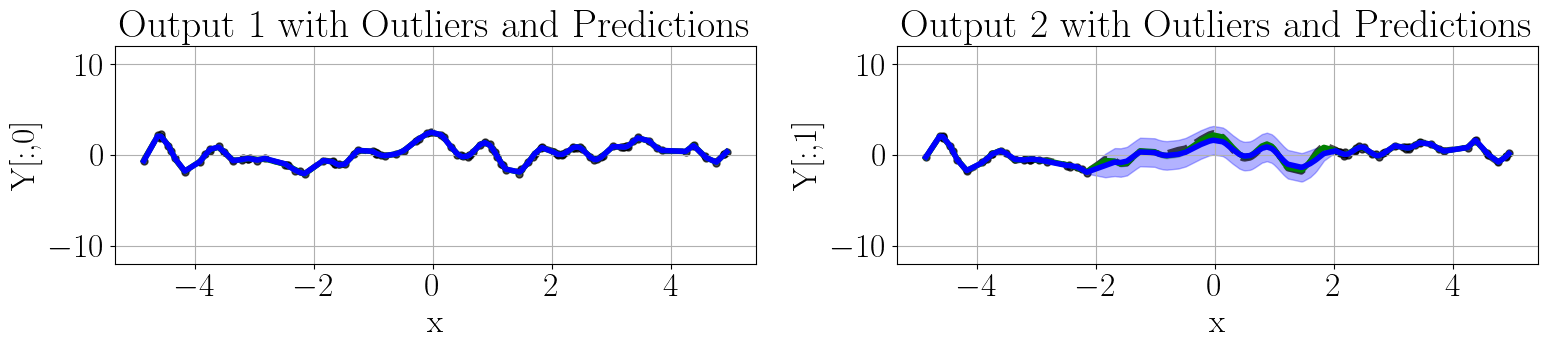

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # 1 row, 2 columns

# First output (column 0)
axes[0].plot(x, F[:, 0], '--', color='black', alpha=0.7, label='True')
axes[0].scatter(x, Y_train[:, 0], color='black', alpha=0.7, label='Training data')

axes[0].plot(x, mu_mogp[:, 0], color='green', label='MOGP mean')
axes[0].fill_between(x.ravel(),
                     mu_mogp[:, 0] - std_mogp[:, 0],
                     mu_mogp[:, 0] + std_mogp[:, 0],
                     color='green', alpha=0.3, label='±1 std')

axes[0].plot(x, mu_morcgp[:, 0], color='blue', label='MORCGP mean')
axes[0].fill_between(x.ravel(),
                     mu_morcgp[:, 0] - std_morcgp[:, 0],
                     mu_morcgp[:, 0] + std_morcgp[:, 0],
                     color='blue', alpha=0.3, label='±1 std')

# axes[0].plot(x, init_gamma[:, 0], color='orange', label='Init gamma')
# axes[0].fill_between(x.ravel(),
#                      init_gamma[:, 0] - init_c[:, 0],
#                      init_gamma[:, 0] + init_c[:, 0],
#                      color='orange', alpha=0.3, label='±1 std')

# axes[0].plot(x, gamma[:, 0], color='red', label='Gamma')
# axes[0].fill_between(x.ravel(),
#                      gamma[:, 0] - c[:, 0],
#                      gamma[:, 0] + c[:, 0],
#                      color='red', alpha=0.3, label='±1 std')

axes[0].set_title("Output 1 with Outliers and Predictions")
axes[0].set_xlabel("x")
axes[0].set_ylabel("Y[:,0]")
axes[0].set_ylim(-12, 12)
axes[0].grid(True)
# axes[0].legend()

# Second output (column 1)
axes[1].plot(x, F[:, 1], '--', color='black', alpha=0.7, label='True')
axes[1].scatter(x, Y_train[:, 1], color='black', alpha=0.7, label='Training data')

axes[1].plot(x, mu_mogp[:, 1], color='green', label='MOGP mean')
axes[1].fill_between(x.ravel(),
                     mu_mogp[:, 1] - std_mogp[:, 1],
                     mu_mogp[:, 1] + std_mogp[:, 1],
                     color='green', alpha=0.3, label='±1 std')

axes[1].plot(x, mu_morcgp[:, 1], color='blue', label='MORCGP mean')
axes[1].fill_between(x.ravel(),
                     mu_morcgp[:, 1] - std_morcgp[:, 1],
                     mu_morcgp[:, 1] + std_morcgp[:, 1],
                     color='blue', alpha=0.3, label='±1 std')

# axes[1].plot(x, init_gamma[:, 1], color='orange', label='Init gamma')
# axes[1].fill_between(x.ravel(),
#                      init_gamma[:, 1] - init_c[:, 1],
#                      init_gamma[:, 1] + init_c[:, 1],
#                      color='orange', alpha=0.3, label='±1 std')

# axes[1].plot(x, gamma[:, 1], color='red', label='Gamma')
# axes[1].fill_between(x.ravel(),
#                      gamma[:, 1] - c[:, 1],
#                      gamma[:, 1] + c[:, 1],
#                      color='red', alpha=0.3, label='±1 std')

axes[1].set_title("Output 2 with Outliers and Predictions")
axes[1].set_xlabel("x")
axes[1].set_ylabel("Y[:,1]")
axes[1].set_ylim(-12, 12)
axes[1].grid(True)
# axes[1].legend()

plt.tight_layout()
plt.show()
